# **Project Pipeline**

| **Steps**                                              | **Script files**                          |
|-----------------------------------------------------------|-------------------------------------------|
| 1) Read and pre-process data                              | pre_processing.py                         |
| 2) Feature engineering                                    | feature_engineering.py                    |
| 3) Train models                                           | model_training.py, <br>tree_model_training.py |
| 4) Predict on test_features <br>and write submission file | final_predict.py                          |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scripts.pre_processing as pp
import scripts.feature_engineering as fe
import scripts.tree_model_training as tm
import scripts.linear_model_training as lm
from scripts.model_evaluation import regression_evaluation
import scripts.final_predict as fp

## 1) Pre-process data

In [2]:
# Read in data files 
train_features = pd.read_csv('./data/dengue_features_train.csv')
train_target = pd.read_csv('./data/dengue_labels_train.csv')
test_features = pd.read_csv('./data/dengue_features_test.csv')

In [3]:
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=False)

# Run processing and split by city
train_iq = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=False)
train_sj = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=False)

# Run checks for missing values
assert train_iq.isnull().any().any() == False
assert train_sj.isnull().any().any() == False
Xy_iq = train_iq.copy()
Xy_sj = train_sj.copy()
print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (463, 24)
train_sj shape: (928, 24)


## 2) Feature engineering

In [4]:
# Run feature engineering 
Xy_iq = fe.cyclical_encode_date(Xy_iq)
Xy_sj = fe.cyclical_encode_date(Xy_sj)
#Xy_iq = fe.shift_features(Xy_iq, periods=1)
#Xy_sj = fe.shift_features(Xy_sj, periods=1)
Xy_iq = fe.drop_date(Xy_iq)
Xy_sj = fe.drop_date(Xy_sj)
Xy_iq = fe.add_rolling(Xy_iq, 'iq', fillna=True)
Xy_sj = fe.add_rolling(Xy_sj, 'sj', fillna=True)
Xy_iq = fe.remove_original_cols(Xy_iq)
Xy_sj = fe.remove_original_cols(Xy_sj)
print(f'train_iq shape: {Xy_iq.shape}') 
print(f'train_sj shape: {Xy_sj.shape}') 

train_iq shape: (463, 22)
train_sj shape: (928, 22)


Text(0.5, 1.0, 'San Juan Variable Correlations')

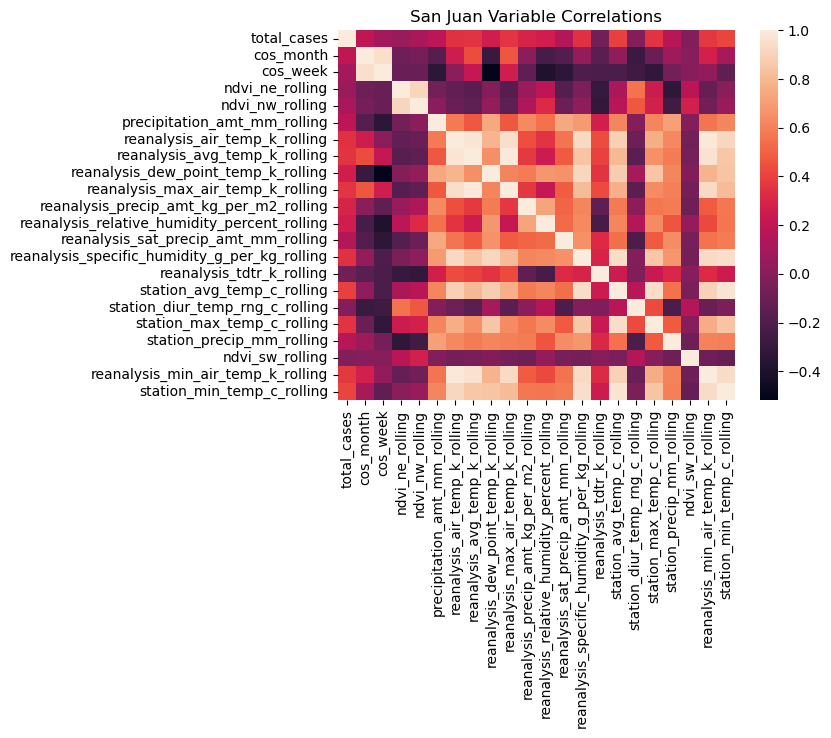

In [5]:
sj_corr_heat = sns.heatmap(Xy_sj.corr())
plt.title('San Juan Variable Correlations')


In [6]:
#(Xy_sj.total_cases
#   .drop('total_cases', axis=1) # don't compare with myself
#   .sort_values(ascending=False)
#   .plot
#   .barh())

In [7]:
# Split data into X and y
X_iq = Xy_iq.drop(labels=['total_cases'], axis=1)
y_iq = Xy_iq['total_cases']
X_sj = Xy_sj.drop(labels=['total_cases'], axis=1)
y_sj = Xy_sj['total_cases']
assert len(X_iq) == len(y_iq)

## 3) Train models

### Baseline model

In [8]:
# Baseline model predictions for Iquitos (Iq)
bl_pred_train = np.tile(np.mean(y_iq), len(y_iq))
bl_pred_test = np.tile(np.mean(y_iq), len(y_iq))
print('For Iquitos: ')
regression_evaluation(y_iq, y_iq, bl_pred_train, bl_pred_test)

# Baseline model predictions for San Jose (sj)
bl_pred_train = np.tile(np.mean(y_sj), len(y_sj))
bl_pred_test = np.tile(np.mean(y_sj), len(y_sj))
print('For San Jose: ')
regression_evaluation(y_sj, y_sj, bl_pred_train, bl_pred_test)

For Iquitos: 

    Evaluation metrics:
        RMSE train: 9.24327523359923
        RMSE test: 9.24327523359923
        MAE train: 6.380110930218457
        MAE test: 6.380110930218457 
    
For San Jose: 

    Evaluation metrics:
        RMSE train: 39.06484683794444
        RMSE test: 39.06484683794444
        MAE train: 24.198600995838284
        MAE test: 24.198600995838284 
    


(39.06484683794444, 39.06484683794444, 24.198600995838284, 24.198600995838284)

### Poisson regression model

In [9]:
# Poisson regression model for iq
X, y = X_iq, y_iq
lm.poisson_reg_model(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converg

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,8.078290,5.056153,4.988233,3.711275,0.6,100
1,1,8.151113,4.987150,5.070079,3.644013,0.6,200
2,1,8.474232,5.523628,5.246042,3.959918,1.0,100
3,1,8.309519,5.187246,5.119233,3.769032,1.0,200
4,2,12.572613,6.164668,8.812479,4.313961,0.6,100
5,2,12.509580,6.122177,8.689656,4.300104,0.6,200
6,2,12.458046,6.204988,8.652341,4.356718,1.0,100
7,2,12.452339,6.166898,8.589171,4.340552,1.0,200


In [10]:
# Poisson regression model for sj
X, y = X_sj, y_sj
lm.poisson_reg_model(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/DSR-comp/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:284: ConvergenceWarning: lbfgs failed to converg

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,alpha,mat_iter
0,1,55.416443,28.205653,33.872039,17.856713,0.6,100
1,1,90.417699,20.372544,60.260186,13.767421,0.6,200
2,1,81.524028,20.953977,55.073860,14.091257,1.0,100
3,1,78.550835,21.438583,52.833337,14.090611,1.0,200
4,2,33.323309,37.338462,25.325313,21.820185,0.6,100
5,2,32.581147,36.344658,24.722197,21.379160,0.6,200
6,2,29.997155,36.755073,23.262889,21.566804,1.0,100
7,2,33.583573,35.542425,25.641750,21.211580,1.0,200


<Axes: >

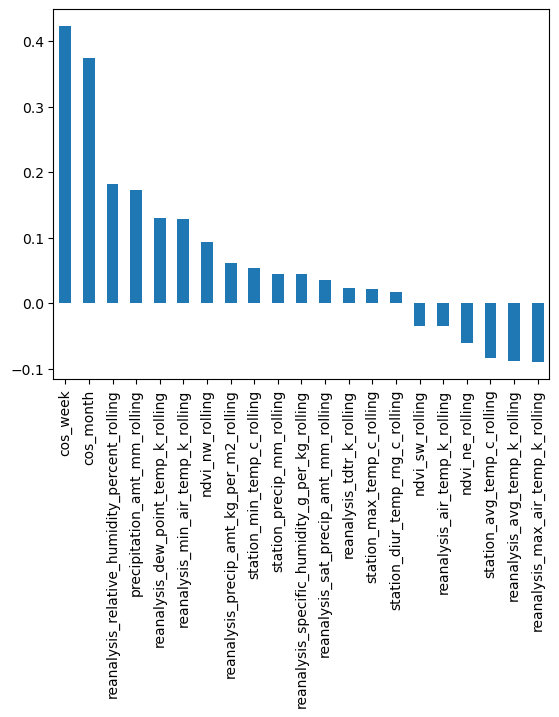

In [11]:
# Poisson get parameters for iq 
X, y = X_iq, y_iq
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

<Axes: >

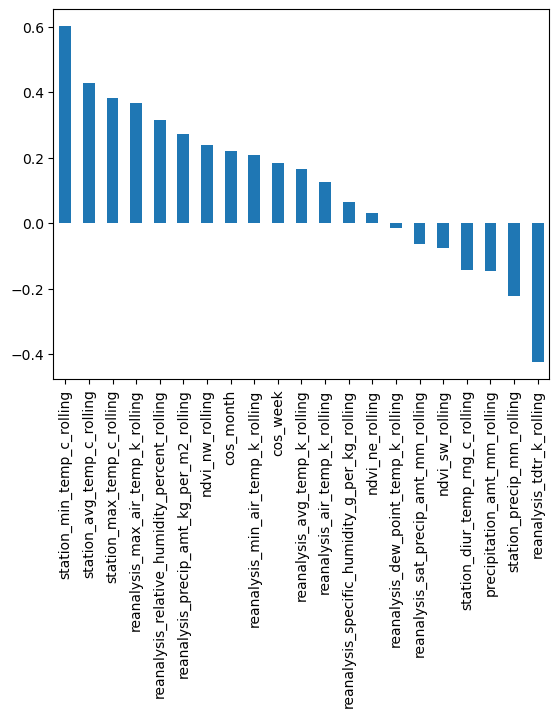

In [12]:
# Poisson get parameters for sj 
X, y = X_sj, y_sj
coefs = lm.poisson_get_coefs(X, y)
coefs.sort_values(ascending=False).plot.bar()

### Random forest model

In [13]:
# Random forest model for iq
X, y = X_iq, y_iq
tm.rforest_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,n_estimators,max_depth,min_samples_split,min_samples_leaf
0,1,7.928716,3.542708,5.175928,2.549797,100,4,2,2
1,1,8.032950,3.579421,5.312431,2.570912,100,4,5,2
2,1,8.079947,2.493051,5.338738,1.635600,100,8,2,2
3,1,7.965237,2.579931,5.262688,1.674568,100,8,5,2
4,1,7.977008,3.432552,5.232488,2.526106,200,4,2,2
5,1,7.939118,3.525973,5.196605,2.493769,200,4,5,2
6,1,7.998584,2.485608,5.264117,1.647810,200,8,2,2
7,1,7.955266,2.581964,5.231068,1.673686,200,8,5,2
8,2,11.376384,4.789057,7.153525,3.399026,100,4,2,2
9,2,11.586513,4.926395,7.191038,3.457378,100,4,5,2


In [16]:
# Random forest model for sj
X, y = X_sj, y_sj
tm.rforest_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,n_estimators,max_depth,min_samples_split,min_samples_leaf
0,1,42.698119,15.607381,31.529535,10.018173,100,4,2,2
1,1,46.580760,14.841909,34.760929,9.786686,100,4,5,2
2,1,44.100079,9.323003,31.740088,5.203836,100,8,2,2
3,1,49.319218,10.166108,37.331572,5.682583,100,8,5,2
4,1,43.332960,15.243310,32.659905,9.952292,200,4,2,2
5,1,44.790100,15.361103,34.003428,10.112697,200,4,5,2
6,1,43.974262,9.376209,32.874243,5.356388,200,8,2,2
7,1,45.458916,9.961780,34.033405,5.508108,200,8,5,2
8,2,31.632594,23.721503,27.268756,15.070116,100,4,2,2
9,2,30.760976,23.166652,26.082330,14.863356,100,4,5,2


<Axes: >

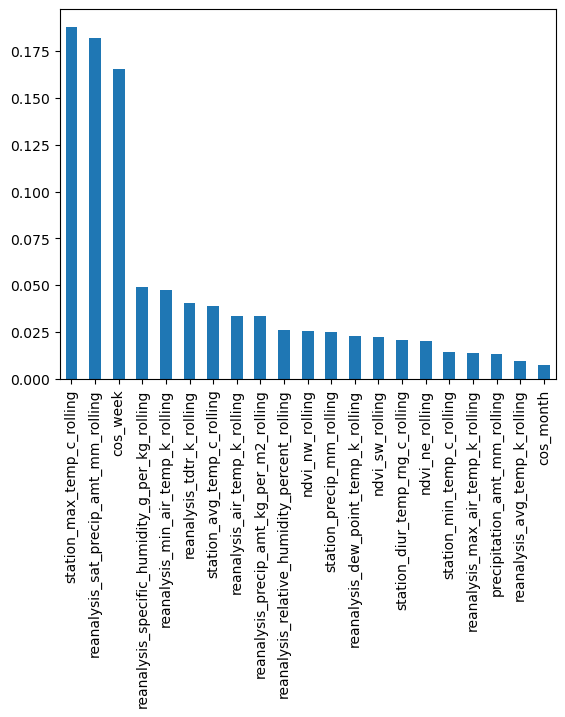

In [17]:
# Random forest feature importance for iq
X, y = X_iq, y_iq
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

<Axes: >

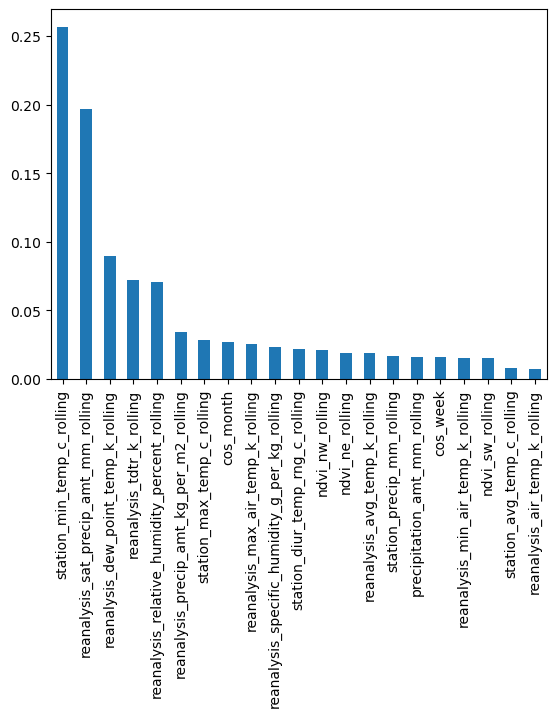

In [18]:
# Random forest feature importance for sj
X, y = X_sj, y_sj
feature_importances = tm.rf_feature_importance(X, y)
feature_importances.sort_values(ascending=False).plot.bar()

### XGBoost model

In [19]:
# XG boost model for iq
X, y = X_iq, y_iq
tm.xg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
0,1,8.448834,2.246506,5.508515,1.365537,0.05,100,4,0.6,0.8,5,10
1,1,8.299643,2.755534,5.413898,1.612333,0.05,100,4,0.6,0.8,10,10
2,1,8.371260,3.450774,5.518874,1.970606,0.05,100,4,0.6,0.8,20,10
3,1,8.425730,2.156047,5.498488,1.293582,0.05,100,5,0.6,0.8,5,10
4,1,8.182474,2.682537,5.312353,1.537413,0.05,100,5,0.6,0.8,10,10
5,1,8.367856,3.365855,5.540215,1.893539,0.05,100,5,0.6,0.8,20,10
6,1,8.364985,2.136890,5.405986,1.259809,0.05,100,6,0.6,0.8,5,10
7,1,8.180128,2.637492,5.290895,1.495606,0.05,100,6,0.6,0.8,10,10
8,1,8.344236,3.342586,5.507200,1.874714,0.05,100,6,0.6,0.8,20,10
9,2,12.022242,2.720697,7.536092,1.792088,0.05,100,4,0.6,0.8,5,10


In [20]:
# XG boost model for sj
X, y = X_sj, y_sj
tm.xg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_test,mae_train,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda,gamma
0,1,46.910965,9.354819,31.827740,4.684922,0.05,100,4,0.6,0.8,5,10
1,1,45.139967,13.379979,29.201191,5.604201,0.05,100,4,0.6,0.8,10,10
2,1,43.058046,18.427317,24.961970,6.771533,0.05,100,4,0.6,0.8,20,10
3,1,45.272638,8.694019,29.646468,3.878841,0.05,100,5,0.6,0.8,5,10
4,1,43.750724,13.108909,26.285055,4.958279,0.05,100,5,0.6,0.8,10,10
5,1,42.729479,18.074365,23.655097,6.318271,0.05,100,5,0.6,0.8,20,10
6,1,44.669047,8.565684,28.938457,3.494187,0.05,100,6,0.6,0.8,5,10
7,1,43.379389,12.925129,25.498828,4.702222,0.05,100,6,0.6,0.8,10,10
8,1,42.521687,17.937667,23.714865,6.106715,0.05,100,6,0.6,0.8,20,10
9,2,28.343101,12.800673,22.833325,7.670477,0.05,100,4,0.6,0.8,5,10


## 4) Predict on test data with chosen model and write file

Repeat the above transforms on the test set

In [21]:
# Code to run pipeline on dataset including test_features, and then take only test_features to run the final model
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=True)

# Run processing and split by city
Xy_iq_comb = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=True)
Xy_sj_comb = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=True)
assert Xy_iq_comb.isnull().any().any() == False
assert Xy_sj_comb.isnull().any().any() == False

# Run feature engineering 
Xy_iq_comb = fe.cyclical_encode_date(Xy_iq_comb)
Xy_sj_comb = fe.cyclical_encode_date(Xy_sj_comb)
#Xy_iq_comb = fe.shift_features(Xy_iq_comb, periods=1)
#Xy_sj_comb = fe.shift_features(Xy_sj_comb, periods=1)
Xy_iq_comb = fe.drop_date(Xy_iq_comb)
Xy_sj_comb = fe.drop_date(Xy_sj_comb)
Xy_iq_comb = fe.add_rolling(Xy_iq_comb, 'iq', fillna=True)
Xy_sj_comb = fe.add_rolling(Xy_sj_comb, 'sj', fillna=True)
Xy_iq_comb = fe.remove_original_cols(Xy_iq_comb)
Xy_sj_comb = fe.remove_original_cols(Xy_sj_comb)
print(f'Xy_iq_comb shape: {Xy_iq_comb.shape}') 
print(f'Xy_sj_comb shape: {Xy_sj_comb.shape}') 

# Split data into X and y
X_iq_comb = Xy_iq_comb.drop(labels=['total_cases'], axis=1)
y_train_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] >= 0, Xy_iq_comb.columns == 'total_cases']
y_test_iq = Xy_iq_comb.loc[Xy_iq_comb['total_cases'] < 0, Xy_iq_comb.columns == 'total_cases']
X_sj_comb = Xy_sj_comb.drop(labels=['total_cases'], axis=1)
y_train_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] >= 0, Xy_sj_comb.columns == 'total_cases']
y_test_sj = Xy_sj_comb.loc[Xy_sj_comb['total_cases'] < 0, Xy_sj_comb.columns == 'total_cases']

# Take now only the test features 
X_train_iq = X_iq_comb.iloc[:(X_iq_comb.shape[0] - y_test_iq.shape[0]) , :]
X_train_sj = X_sj_comb.iloc[:(X_sj_comb.shape[0] - y_test_sj.shape[0]) , :]
X_test_iq = X_iq_comb.iloc[(X_iq_comb.shape[0] - y_test_iq.shape[0]): , :]
X_test_sj = X_sj_comb.iloc[(X_sj_comb.shape[0] - y_test_sj.shape[0]): , :]

print(X_train_iq.shape, y_train_iq.shape)
print(X_train_sj.shape, y_train_sj.shape)
assert (X_train_iq.shape[0] == y_train_iq.shape[0])
assert (X_train_sj.shape[0] == y_train_sj.shape[0])


Xy_iq_comb shape: (619, 22)
Xy_sj_comb shape: (1188, 22)
(463, 21) (463, 1)
(928, 21) (928, 1)


In [40]:
# Select data and chosen model and hyperparameters for final prediction

params = dict(learning_rate=0.05,
        n_estimators=120,
        max_depth=6,
        subsample=0.6,
        colsample_bytree=0.8,
        reg_lambda=8,
        gamma=8)
 
# Iquitos, iq
X_test_iq = X_test_iq
X_train_iq = X_train_iq
y_train_iq = y_train_iq
model_iq = 'XGBRegressor'
params_iq = params

# San Jose, sj
X_test_sj = X_test_sj
X_train_sj = X_train_sj
y_train_sj = y_train_sj
model_sj = 'XGBRegressor'
params_sj = params


In [41]:
# Do final prediction and create final DataFrame for submission 
iq_preds = fp.final_predict(X_test_iq, X_train_iq, y_train_iq, city='iq', model=model_iq, params=params_iq)
sj_preds = fp.final_predict(X_test_sj, X_train_sj, y_train_sj, city='sj', model=model_sj, params=params_sj)
final_iq = test_features.loc[test_features.city == 'iq', ['city','year','weekofyear']]
final_sj = test_features.loc[test_features.city == 'sj', ['city','year','weekofyear']]

assert len(iq_preds) == final_iq.shape[0]
assert len(sj_preds) == final_sj.shape[0]

final_iq['total_cases'] = iq_preds.tolist()
final_sj['total_cases'] = sj_preds.tolist()
final = pd.concat([final_sj, final_iq], axis=0)
final['total_cases'] = final['total_cases'].astype(int)

assert final.isnull().any().any() == False
assert final.shape[0] == 416


In [42]:
preds_train_iq, y_train_iq = fp.preds_for_plot(X_test_iq, X_train_iq, y_train_iq, model=model_iq, params=params_iq)
preds_train_sj, y_train_sj = fp.preds_for_plot(X_test_sj, X_train_sj, y_train_sj, model=model_sj, params=params_sj)

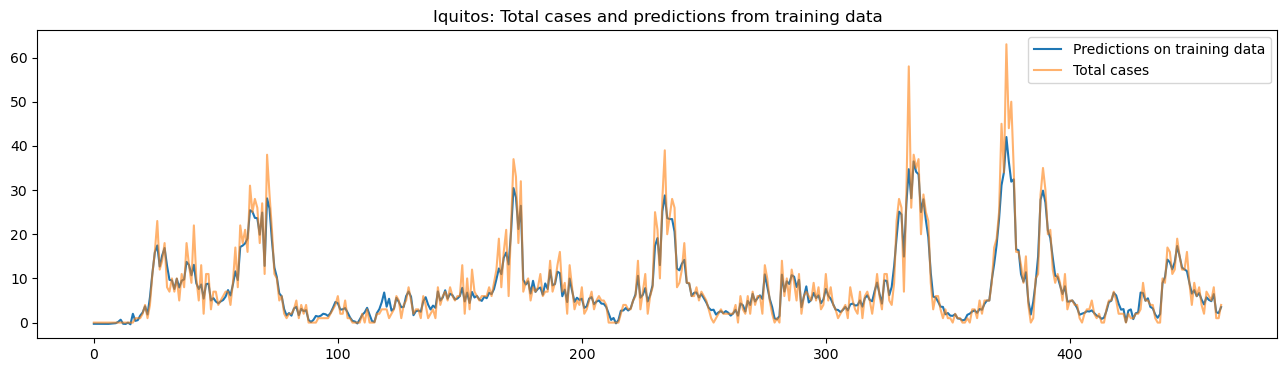

In [43]:
plt.figure(figsize=(16,4))
x = np.arange(preds_train_iq.shape[0])
plt.plot(x, preds_train_iq, label='Predictions on training data')
plt.plot(x, y_train_iq, label='Total cases', alpha=0.6)
plt.title('Iquitos: Total cases and predictions from training data')
plt.legend();

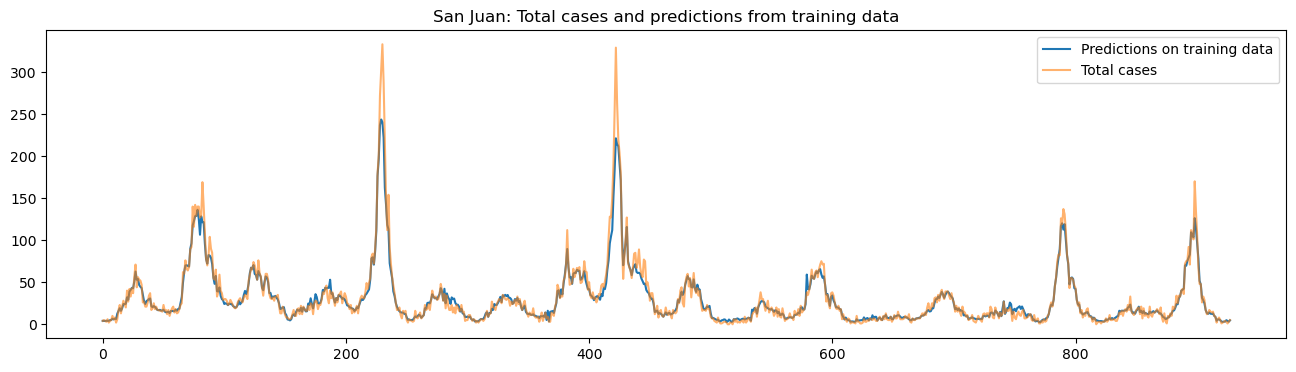

In [44]:
plt.figure(figsize=(16,4))
x = np.arange(preds_train_sj.shape[0])
plt.plot(x, preds_train_sj, label='Predictions on training data')
plt.plot(x, y_train_sj, label='Total cases', alpha=0.6)
plt.title('San Juan: Total cases and predictions from training data')
plt.legend();

In [45]:
# Write to file for submission 
print('Writing submission file to folder: ')
final.to_csv('submission_XGB_less_features.csv', index=False)

Writing submission file to folder: 


SCORE: 26